# Task Two: Dogecoin Forensics Analysis

In [1]:
import requests
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time, datetime
import gzip
import shutil
import csv
import datetime
from datetime import date, timedelta

## Stage 1: Initial window of 90 days

### Importing data

The cryptocurrency token I have chosen to anlayse is Dogecoin. I use the public CoinGecko API (no key needed) to fetch hourly data on price, volume and market caps for Dogecoin. Limits on the free CoinGecko API inlcude only being to access data from earliest 365 days ago, and 90 day window maximum. 

The 90 day window I have chosen to analyses is 10 October 2024 to 8 January 2025. However due to the 365 day limitation, do note that if accessing this past 10 Oct 2025, a later 90 day window will have to be chosen. In this case, the start date will be chosen as one year ago from now (earliest possible), and the end date as 90 days later.

In [16]:
# Get start date
today = datetime.datetime.now()
oct_10_25 = datetime.datetime(2025, 10, 10, 0, 0, 0) # 10 October 2025
if today > oct_10_25:
    start_date = today - timedelta(days = 364)
else:
    start_date = datetime.datetime(2024, 10, 10, 0, 0, 0) # 10 October 2024
print(start_date)

# Get end date (90 days after start date)
end_date = start_date + timedelta(days = 90) 
print(end_date)

# Get UNIX timestamps start and end dates
start_date = start_date.timestamp()
end_date = end_date.timestamp()

2024-10-10 00:00:00
2025-01-08 00:00:00


Next, I fetch the Dogecoin market data from the required window and conver the reponse to JSON.

In [17]:
# CoinGecko API URL
url = "https://api.coingecko.com/api/v3/coins/dogecoin/market_chart/range"

# Parameters for currency and timeframe
params = {
    "vs_currency": "usd",
    "from": start_date,   
    "to": end_date      
}

# Fetch data and convert to JSON
response = requests.get(url, params = params)
data = response.json()
print(data.keys())

dict_keys(['prices', 'market_caps', 'total_volumes'])


I extract the hourly `prices` and `total_volumes` data from the dictionary and merge into a single dataframe called `df_pv` which has 2111 observations.

In [18]:
df_p = pd.DataFrame(data["prices"], columns = ["timestamp", "price"])
df_v = pd.DataFrame(data["total_volumes"], columns = ["timestamp", "volume"])
df_pv = pd.merge(df_p , df_v, on = "timestamp", how = "inner")
print(df_pv.head(5))
print(df_pv.shape) # (2111, 3)

       timestamp     price        volume
0  1728490398695  0.110174  6.967202e+08
1  1728493361824  0.109644  7.037256e+08
2  1728497145400  0.110121  6.829742e+08
3  1728500642575  0.108490  6.960833e+08
4  1728504097402  0.109010  6.995237e+08
(2159, 3)


### Data preperation

To prepare the data for analysis, I convert the column types appropriately, converting `timestamp` columns to datetime type, as well as `price` and `volume` columns to float type.

In [19]:

df_pv["timestamp"] = pd.to_datetime(pd.to_numeric(df_pv["timestamp"]), unit = "ms")
df_pv["price"] = df_pv["price"].astype(float)
df_pv["volume"] = df_pv["volume"].astype(float)

### Visualisation of hourly price and volume over 90 days

To visualise the changes in hourly price and volume over 90 days, I plot the a single plot containing volume data as a blue bar plot and price data as a red line plot. I identify the largest volume spike and annotate it on the graph.

### Initial visualisation 

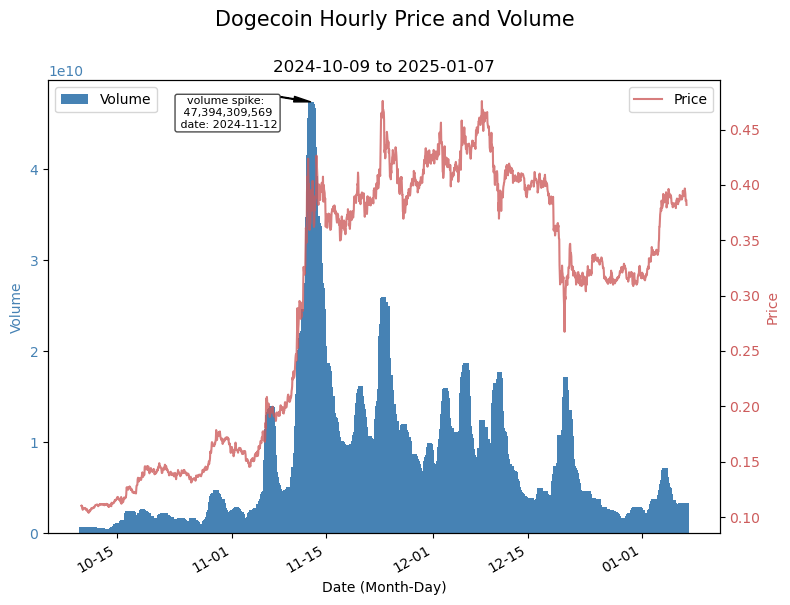

In [20]:
# Define duration window
first_date = min(df_pv["timestamp"]).date() 
last_date = max(df_pv["timestamp"]).date() 

# Define variables to plot
y1 = df_pv["volume"] 
y2 = df_pv["price"] 
x = df_pv["timestamp"] 

fig, ax1 = plt.subplots(figsize = (8,6)) 

# Plot barplot for volume on primary y-axis 
ax1.bar(x, y1, color = "steelblue", label = "Volume") 
ax1.set_xlabel("Date (Month-Day)") 
ax1.set_ylabel("Volume", color = "steelblue") 
ax1.tick_params(axis = "y", labelcolor = "steelblue") 

# Plot lineplot for price on secondary y-axis 
ax2 = ax1.twinx() 
ax2.plot(x, y2, color = "indianred", alpha = 0.8, label = "Price") 
ax2.set_ylabel("Price", color = "indianred") 
ax2.tick_params(axis = "y", labelcolor = "indianred") 

# Create annotation for highest volume spike
annotation = df_pv.nlargest(1, "volume")[["timestamp", "volume"]].iloc[0]
ax1.annotate(
        f"volume spike: \n {int(annotation["volume"]):,} \n date: {annotation["timestamp"].date()}",
        xy = (annotation["timestamp"], annotation["volume"]), xycoords = "data",
        xytext = (-60, -20), textcoords = "offset points", fontsize = 8,
        ha = "center", va = "bottom",
        arrowprops = dict(facecolor = "black", shrink = 0.01, width = 0.5, headwidth = 4),
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "black", boxstyle = "round,pad=0.2")
        )    

# Create legends 
legend1 = ax1.legend(loc = "upper left") 
legend2 = ax2.legend(loc = "upper right") 

# Format and show 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) 
fig.autofmt_xdate() 
plt.suptitle("Dogecoin Hourly Price and Volume", y = 1, fontsize = 15) 
plt.title(f"{first_date} to {last_date}", fontsize = 12) 
fig.tight_layout() # Adjust layout to prevent labels from overlapping 
plt.show()

As seen from the graph, the highest volume spike of 47,394,309,569 occured on 12 November 2024. Hence, I decide to zoom into the week of 9-15 November 2024 for further analysis.

## Stage 2: Zooming in to week of 9-15 November 2024

### Importing data

**Note: To sve time, the next code chunk importing data from the web can be skipped, and data can be read in directly from `df_tx_hourly.csv` in the following code chunk.**

I use the public Blockchair API (no key needed) to fetch transaction level data for Dogecoin during the week of interest. The data contains many columns such as unique transaction blocks id, unique transaction id and hash, date and time of transaction, transaction metadata, trascation input and output data (count, total amount), transaction fee, as well as Coins Days Destroyed (CDD) metric.

I choose to keep only a few columns of interest:
1. `time`: full timestamp (YYYY-MM-DD HH:MM:SS) of transaction
2. `output_count`: number of outputs (wallets receiving DOGE from this transaction)
3. `output_total_usd`: total DOGE amount (in USD) going to outputs in this transatcion 
4. `cdd_total`: Coins Days Destroyed (CDD); high CDD indicates older coins moving

In order to be cohesive with the price and volume data in `df_pv`, I round all timestamps to the nearest hour before aggregating transactions (rows) by hour, computing the sum of all entries in that hour.

In [21]:
# Define columns of interest to keep
target_cols = ["time", "input_count", "output_count", "output_total_usd", "cdd_total"]

list_of_dfs = []

# For loop to loop through week of 9-15 Nov 2025 (7 days)
for i in range(9, 16):  
    date = f"202411{i:02d}"  # Ensures 2-digit day in string
    url = f"https://gz.blockchair.com/dogecoin/transactions/blockchair_dogecoin_transactions_{date}.tsv.gz"
    filename = f"blockchair_dogecoin_transactions_{date}.tsv.gz"

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    with gzip.open(filename, "rb") as f_in:
        with open(filename.replace(".gz", ""), "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Read in chunks for efficiency
    chunks = pd.read_csv(
        filename.replace(".gz", ""), 
        sep = "\t", 
        usecols = target_cols, 
        chunksize = 100000
    )
    
    # Convert column types inside each chunk
    for chunk in chunks: 
        chunk = chunk.astype({
            "input_count": "int32",
            "output_count": "int32",
            "output_total_usd": "int32",
            "cdd_total": "float32"
        })

        # Round timestamp to nearest hour to match df_pv timestamps
        chunk["time"] = pd.to_datetime(chunk["time"]).dt.round("h")

        # Group by hour and compute sum across all transactions in that hour
        chunk_grouped = chunk.groupby("time").sum(numeric_only = True)
        list_of_dfs.append(chunk_grouped)

# Concatenate dataframes across all 7 days
df_tx_hourly = pd.concat(list_of_dfs).groupby("time").sum().reset_index()

# Save as CSV file
df_tx_hourly.to_csv("../data/df_tx_hourly.csv", index = False)

KeyboardInterrupt: 

### Data preparation

To prepare the data for analysis, I convert the column types appropriately, converting `output_count` and `output_total_usd` columns to int type, `cdd_total` column to float type, and `timestamp` columns to datetime type.

In [22]:
df_tx_hourly = pd.read_csv("../data/df_tx_hourly.csv")
df_tx_hourly[["input_count", "output_count", "output_total_usd"]] = df_tx_hourly[["input_count", "output_count", "output_total_usd"]].astype(int)
df_tx_hourly["cdd_total"] = df_tx_hourly["cdd_total"].astype(float)
df_tx_hourly["time"] = pd.to_datetime(df_tx_hourly["time"])   

Next, I filter price and volume data in `df_pv` for the week of interest, rounding the `timestamp` column to the nearest hour so that it can be used as a key for joining with transcation level data in `df_tx_hourly`.

In [23]:
df_pv = df_pv[(df_pv["timestamp"] >= pd.to_datetime("2024-11-09")) & 
              (df_pv["timestamp"] < pd.to_datetime("2024-11-16"))]
df_pv["timestamp"] = df_pv["timestamp"].dt.round("h")
df_pv.rename(columns = {"timestamp": "time"}, inplace = True)
df_pv.to_csv("../data/df_pv.csv", index = False) # Save as csv

I merge the two dataframes into one large dataframe called `DF`, containing columns `time`, `input_count`, `output_count`, `output_total_usd`, `cdd_total`, `price`, and `volume`. The dataframe has 168 (24 hours times 7 days) observations in total.

In [24]:
DF = pd.merge(df_tx_hourly , df_pv, on = "time", how = "inner")
DF.to_csv("../data/DF.csv", index = False) # save as csv
print(DF.columns)
print(DF.shape) # (168, 7)

Index(['time', 'input_count', 'output_count', 'output_total_usd', 'cdd_total',
       'price', 'volume'],
      dtype='object')
(168, 7)


### Visualisation or hourly transaction output value over one week 

To visualise the change in total hourly transaction ouptut value over the week, I plot a single plot containing volume data as a blue bar plot and output value as a red line plot. I identify the three largest ouptut spikes and annotate it on the graph.

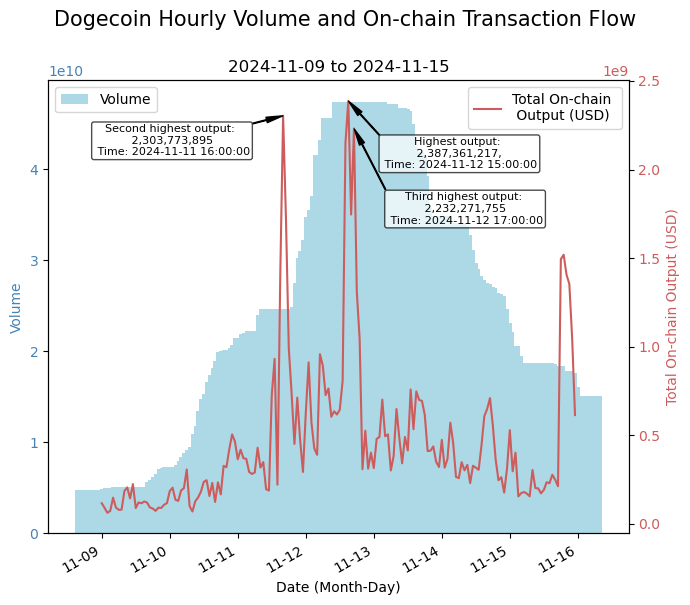

In [25]:
# Get 3 largest hourly output values
high_output_total = DF.nlargest(3, "output_total_usd")[["time", "output_total_usd"]]

# Define duration window
first_date = min(DF["time"]).date() 
last_date = max(DF["time"]).date() 

# Define variables to plot
y1 = DF["volume"] 
y2 = DF["output_total_usd"] 
x = DF["time"] 

fig, ax1 = plt.subplots(figsize = (7,6)) 

# Plot barplot for volume on primary y-axis 
ax1.bar(x, y1, color = "lightblue", label = "Volume") 
ax1.set_xlabel("Date (Month-Day)") 
ax1.set_ylabel("Volume", color = "steelblue") 
ax1.tick_params(axis = "y", labelcolor = "steelblue") 

# Plot lineplot for on-chain transaction flow on secondary y-axis 
ax2 = ax1.twinx() 
ax2.plot(x, y2, color = "indianred", label = "Total On-chain \n Output (USD)") 
ax2.set_ylabel("Total On-chain Output (USD)", color = "indianred") 
ax2.tick_params(axis = "y", labelcolor = "indianred") 

# Create annotations for 2 highest hourly outputs
highest = high_output_total.iloc[0]
ax2.annotate(
        f"Highest output: \n {int(highest["output_total_usd"]):,}, \n Time: {highest["time"]}",
        xy = (highest["time"], highest["output_total_usd"]), xycoords = "data",
        xytext = (80, -50), textcoords = "offset points", fontsize = 8,
        ha = "center", va = "bottom",
        arrowprops = dict(facecolor = "black", shrink = 0.01, width = 0.5, headwidth = 4),
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "black", boxstyle = "round,pad=0.2")
        )

highest2 = high_output_total.iloc[1]
ax2.annotate(
        f"Second highest output: \n {int(highest2["output_total_usd"]):,} \n Time: {highest2["time"]}",
        xy = (highest2["time"], highest2["output_total_usd"]), xycoords = "data",
        xytext = (-80, -30), textcoords = "offset points", fontsize = 8,
        ha = "center", va = "bottom",
        arrowprops = dict(facecolor = "black", shrink = 0.01, width = 0.5, headwidth = 4),
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "black", boxstyle = "round,pad=0.2")
        )   

highest3 = high_output_total.iloc[2]
ax2.annotate(
        f"Third highest output: \n {int(highest3["output_total_usd"]):,} \n Time: {highest3["time"]}",
        xy = (highest3["time"], highest3["output_total_usd"]), xycoords = "data",
        xytext = (80, -70), textcoords = "offset points", fontsize = 8,
        ha = "center", va = "bottom",
        arrowprops = dict(facecolor = "black", shrink = 0.01, width = 0.5, headwidth = 4),
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "black", boxstyle = "round,pad=0.2")
        )        

# Create legends 
legend1 = ax1.legend(loc = "upper left") 
legend2 = ax2.legend(loc = "upper right") 

# Format and show 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) 
fig.autofmt_xdate() 

plt.suptitle("Dogecoin Hourly Volume and On-chain Transaction Flow", y = 1, fontsize = 15) 
plt.title(f"{first_date} to {last_date}", fontsize = 12) 
fig.tight_layout()  
plt.show()

From the graph, it can be seen that all 3 highest output spikes are quite close in value. One spike occured earlier on 11 November 2024 at 4pm, while the other 2 occured in close proximity on 12 November 3pm and again later that day at 5pm.

### Visualisation or hourly total CDD value over one week 

Next, I visualise the change in total CDD over the week. I plot a single plot containing volume data as a blue bar plot and total CDD value as a green line plot. I identify the large CDD spikes and annotate it on the graph.

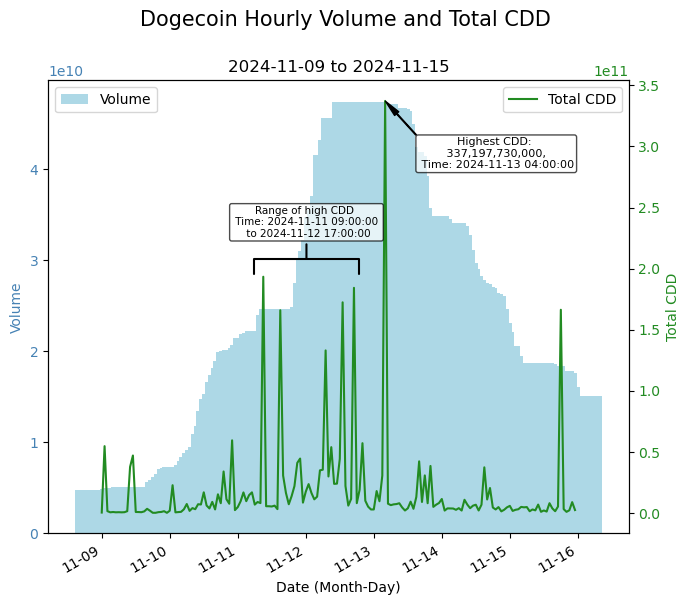

In [27]:
# Get 3 largest hourly total CDD values
high_cdd_total = DF.nlargest(3, "cdd_total")[["time", "volume", "cdd_total"]]

# Define duration window
first_date = min(DF["time"]).date() 
last_date = max(DF["time"]).date() 

# Define variables to plot
y1 = DF["volume"] 
y2 = DF["cdd_total"] 
x = DF["time"] 

fig, ax1 = plt.subplots(figsize = (7,6)) 

# Plot barplot for volume on primary y-axis 
ax1.bar(x, y1, color = "lightblue", label = "Volume") 
ax1.set_xlabel("Date (Month-Day)") 
ax1.set_ylabel("Volume", color = "steelblue") 
ax1.tick_params(axis = "y", labelcolor = "steelblue") 

# Plot lineplot for on-chain CDD on secondary y-axis 
ax2 = ax1.twinx() 
ax2.plot(x, y2, color = "forestgreen", label = "Total CDD") 
ax2.set_ylabel("Total CDD", color = "forestgreen") 
ax2.tick_params(axis = "y", labelcolor = "forestgreen") 

# Create annotations for highest hourly CDD and range
highest = high_cdd_total.iloc[0]
ax2.annotate(
        f"Highest CDD: \n {int(highest["cdd_total"]):,}, \n Time: {highest["time"]}",
        xy = (highest["time"], highest["cdd_total"]), xycoords = "data",
        xytext = (80, -50), textcoords = "offset points", fontsize = 8,
        ha = "center", va = "bottom",
        arrowprops = dict(facecolor = "black", shrink = 0.01, width = 0.5, headwidth = 4),
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "black", boxstyle = "round,pad=0.2")
        )  

ax2.annotate(
        f"Range of high CDD \n Time: {high_cdd_total.iloc[1]["time"]} \n to {high_cdd_total.iloc[2]["time"]}", 
        xy = (0.445, 0.6), xycoords = "axes fraction", 
        xytext = (0.445, 0.65), fontsize = 7.5, 
        ha = "center", va = "bottom",
        arrowprops = dict(arrowstyle = "-[, widthB=5.0, lengthB=1.5", lw = 1.5, color = "black"),
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "black", boxstyle = "round,pad=0.2")
        )

# Create legends 
legend1 = ax1.legend(loc = "upper left") 
legend2 = ax2.legend(loc = "upper right") 

# Format and show 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) 
fig.autofmt_xdate() 

plt.suptitle("Dogecoin Hourly Volume and Total CDD", y = 1, fontsize = 15) 
plt.title(f"{first_date} to {last_date}", fontsize = 12) 
fig.tight_layout()
plt.show()

From the graph, it can be seen that the largest by far CDD spike occured on 13 November 2024 at 4am. A window of moderately large CDD spikes also occured from 11 November 2024 9am to the next day 12 November 2024 5pm.

#### Conclusion
From these 2 visualisations, I identify 2 periods of interest during this one week window:

Period of interest 1: 11 November 2024 3-5pm

Rationale: Output suddenly spiked at 4pm, which fell within a broader elevated CDD window (11 Nobemver 9am to next day 5pm). This overlap is interesting because high output total suggests large amounts of Dogecoin were moved, and high CDD means coins with long dormancy were being spent. This combination may imply large, old wallets were suddenly moving significant funds, an potential precursor of market manipulation.

Period of interest 2: 12 November 3pm to 13 November 4am

Rationale: Two more large output spikes were observed in quick succession on 12 November 3pm and 5pm, followed by the single biggest CDD spike on 13 November 4am. This sequence of movements warrants closer inspection for suspicious activity because large outputs suggests huge amounts of Dogecoin being moved (possibley to exchanges or distribution wallets), followed within hours by a high CDD spike indicating dormant coins being spent and long-term holders unloading. This lag between the output spikes and the CDD spike suggests a multi-phase operation (funds positioned first, then heavy selling/dumping hours later).

## Stage 3: Zooming in even further to 3 day window of interest

### Importing data
Note: To sve time, the next code chunk importing data from the web can be skipped, and data can be read in directly from `df_tx_11.csv` in the following code chunk.

The public Blockahri API is used again to fetch transaction level data for Dogecoin during these 3 day window of interest. Similar to the previous import, the same columns of interest were kept. However this time, observations weren't aggregated by hour, and were instead kept as they are so they could be analysed individually.

In [ ]:
# Define columns of interest to keep
target_cols = ["time", "input_count", "output_count", "output_total_usd", "cdd_total"]

# Define dates of interest: 11-13 Nov 2024
dates = ["20241111", "20241112", "20241113"] 

list_of_chunks = []  

for date in dates:
    url = f"https://gz.blockchair.com/dogecoin/transactions/blockchair_dogecoin_transactions_{date}.tsv.gz"
    filename = f"blockchair_dogecoin_transactions_{date}.tsv.gz"

    # Download compressed file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    # Unzip
    with gzip.open(filename, "rb") as f_in:
        with open(filename.replace(".gz", ""), "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Read in chunks and convert column types for efficiency
    for chunk in pd.read_csv(
        filename.replace(".gz", ""), 
        sep="\t", 
        usecols=target_cols, 
        chunksize=100000
    ):
        chunk = chunk.astype({
            "input_count": "int32",
            "output_count": "int32",
            "output_total_usd": "int32",
            "cdd_total": "float32"
        })
        list_of_chunks.append(chunk)

# Concatenate chunks across all 3 days into one dataframe
df_tx_11 = pd.concat(list_of_chunks, ignore_index = True)

# Save as CSV file
df_tx_11.to_csv("../data/df_tx_11.csv", index = False)

### Data preparation

To prepare the data for analysis, I convert the column types appropriately, converting `output_count` and `output_total_usd` columns to int type, `cdd_total` column to float type, and `timestamp` columns to datetime type.

In [13]:
df_tx_11 = pd.read_csv("../data/df_tx_11.csv")
df_tx_11[["input_count", "output_count", "output_total_usd"]] = df_tx_11[["input_count", "output_count", "output_total_usd"]].astype(int)
df_tx_11["cdd_total"] = df_tx_11["cdd_total"].astype(float)
df_tx_11["time"] = pd.to_datetime(df_tx_11["time"]) 

### Data visualisation for period 1: 11 November 3-5pm

Defining appropriate start and end dates, I filter data and save it in a dataframe named `period_1` for anlysis.

In [14]:
start_time = "2024-11-11 15:00:00"
end_time = "2024-11-11 17:00:00"
period_1 = df_tx_11[(df_tx_11["time"] >= start_time) & (df_tx_11["time"] <= end_time)]

#### Plot 1: Histogram of transaction output values

I plot a histogram of transaction output values across the period. The x-axis displays transaction output in USD, while the y-axis is log-scaled frequency.

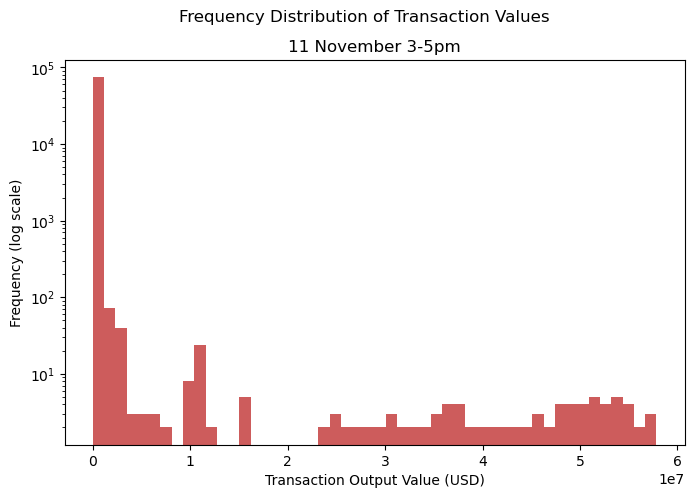

In [15]:
plt.figure(figsize = (8,5))
plt.hist(period_1["output_total_usd"], bins = 50, log = True, color = "indianred")
plt.xlabel("Transaction Output Value (USD)")
plt.ylabel("Frequency (log scale)")
plt.suptitle("Frequency Distribution of Transaction Values")
plt.title("11 November 3-5pm")
plt.show()

From the plot, it can be seen that most transactions are very small (clustered near 0). However, there are a few extremely large transactions in the tens of millions range.

Cryptocurrency transaction distributions are naturally heavy-tailed, due to a few big whales making large transactions while there are many small retail trades. However the sudden abnormal concentration of extremely high-value transactions in a short 2-hour window could indicate coordinated activity. If these large spikes coincide with high CDD activity (coins that haven't moved for a long time suddenly moving), it strengthens the suspicion that whales might be offloading into a pump.

#### Plot 2: Scatterplot of CDD vs Output

Hence, to investigate the relationship between CDD and ouptut value for each transaction, I plot a scatterplot with CDD log-scaled output on the axis and log-scaled CDD on the y-axis.

In [ ]:
plt.figure(figsize = (8,5))
plt.scatter(period_1["output_total_usd"], period_1["cdd_total"], alpha = 0.1, color = "forestgreen")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Transaction Output Value (USD, log scale)")
plt.ylabel("CDD (log scale)")
plt.suptitle("CDD vs Transaction Output Value")
plt.title("11 November 3-5pm")
plt.show()

There is a clear positive relationship between ouptutvalue and CDD: larger outputs generally have higher CDD. This is natural as when someone moves a large amount of money, it is more likely to be an amount that hasn't been moved for a while.

However, there are no outliers in the plot that indicate whales cashing out their position. Hence it is not possible to conlcude from this plot whether pump and dump occured.

### Data visualisation for period 1: 12 November 3pm to 13 November 4am

Defining appropriate start and end dates, I filter data and save it in a dataframe named `period_2` for anlysis.

In [ ]:
start_time = "2024-11-12 15:00:00"
end_time = "2024-11-13 04:00:00"
period_2 = df_tx_11[(df_tx_11["time"] >= start_time) & (df_tx_11["time"] <= end_time)]

#### Plot 1: Histogram of transaction output values 

I plot a histogram of transaction output values across the period. The x-axis displays transaction output in USD, while the y-axis is log-scaled frequency.

In [ ]:
plt.figure(figsize = (8,5))
plt.hist(period_2["output_total_usd"], bins = 50, log = True, color = "indianred")
plt.xlabel("Transaction Output Value (USD)")
plt.ylabel("Frequency (log scale)")
plt.suptitle("Frequency Distribution of Transaction Values")
plt.title("12 November 3pm to 13 November 4am")
plt.show()

In [ ]:
print(max(period_1["output_total_usd"]))
print(max(period_2["output_total_usd"]))
print(round(max(period_2["output_total_usd"]) / max(period_1["output_total_usd"]), 2))

Similar to Period 1, the transaction value distribution in Period 2 is heavy-tailed, indicating that most transactions are small but a few large ones dominate the activity. However, there are important differences between the 2 plots:

1. Period 2 shows a narrow cluster of extremely large outliers, whereas Period 1 displayed a broader range of large transactions spread out more evenly
2. The maximum transaction in Period 2 is approximately 3.73× higher than the maximum observed in Period 1, highlighting an unusual concentration of very large transfers

This pattern suggests that while both periods exhibit abnormal high-value activity, Period 2 displays more extreme transaction behavior, which could potentially indicate coordinated behavior (possibly a single entity or small group making outsized moves), in contrast to Period 1’s more dispersed high-value activity.

Hence, I filter for the 10 largest transactions to look at the values for `input_count` and `output_count`. A high output count may indicate fan-out transactions.

In [ ]:
largest_10_output = period_2.nlargest(10, "output_total_usd")[["time", "input_count", "output_count", "output_total_usd"]]
print(largest_10_output)

From the table, it can be seen that the output counts are all low at 2. Hence this does not indicate fan-out transactions, but is instead consistent with activity by a single entity or a small group, though further wallet-level evidence would be required to confirm this.